In [2]:
#import split data
from sklearn.model_selection import train_test_split
import numpy as np
from scipy.stats import truncnorm
import pandas as pd

In [3]:
import requests
import pandas as pd


# Specify the countries and indicator
countries = "CAN;FIN;ITA;KEN;NOR;SGP"  # ISO codes for Canada, Finland, Italy, Kenya, Norway, Singapore
indicator = "NY.GDP.PCAP.CD"  # GDP per capita (current US$)
years = ["2010","2011","2012","2013","2014","2015","2016","2017","2018","2019","2020","2021","2022","2023"]

gdp_data = {}

for year in years:
        
    url = f"https://api.worldbank.org/v2/country/{countries}/indicator/{indicator}?format=json&date={year}"
    # Fetch the data
    response = requests.get(url)
    data = response.json()

    # Extract relevant data
    for entry in data[1]:
        country = entry['country']['value']
        gdp_per_capita = entry['value']
        year = entry['date']
        if country not in gdp_data:
            gdp_data[country] = {}
            gdp_data[country][year] = gdp_per_capita
        else:
            if year not in gdp_data[country]:
                gdp_data[country][year] = gdp_per_capita


print(gdp_data)


{'Canada': {'2010': 47560.6666009406, '2011': 52223.8588398531, '2012': 52670.3447335415, '2013': 52638.1187235237, '2014': 50960.8431174661, '2015': 43594.1941045394, '2016': 42314.0615817218, '2017': 45129.628116623, '2018': 46539.1761570405, '2019': 46352.8693445211, '2020': 43537.839298904, '2021': 52496.8441693242, '2022': 55509.393176404, '2023': 53431.1857063879}, 'Finland': {'2010': 46506.2919016566, '2011': 51060.3242589767, '2012': 47551.6740841369, '2013': 49691.0145200739, '2014': 50073.7760815871, '2015': 42560.3456767103, '2016': 43451.2562442158, '2017': 46085.0174739036, '2018': 49654.2497035329, '2019': 48358.1807773701, '2020': 48828.6846862799, '2021': 53099.1351400148, '2022': 50438.4753952355, '2023': 52925.6897638424}, 'Italy': {'2010': 36184.7118698678, '2011': 38851.3881339353, '2012': 35235.7989058242, '2013': 35747.707952689, '2014': 35750.7197500382, '2015': 30387.1293187854, '2016': 31126.3246947273, '2017': 32554.14668453, '2018': 34746.3441392416, '2019': 

In [4]:

from sklearn.pipeline import Pipeline
from sklearn.compose import TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
import pandas as pd

def compute_gdp_per_capita(X,gdp_data):
    def get_gdp(row):
        country = str(row["country"])
        year = str(int(row["year"])+2010)
        return gdp_data[country][year]
    X["gdp_per_capita"] = X.apply(get_gdp, axis=1)
    return X

def generate_features(X, train=False):
    X = X.copy()
        
    X["date"] = pd.to_datetime(X["date"], format="%Y-%m-%d")
    X["dayofweek"] = X["date"].dt.dayofweek
    X["month"] = X["date"].dt.month - 1
    X["year"] = X["date"].dt.year - 2010
    X["is_weekend"] = X["dayofweek"].isin([5,6])
    X["sin_dayofweek"] = np.sin(X["dayofweek"] * (2 * np.pi / 7))
    X["cos_dayofweek"] = np.cos(X["dayofweek"] * (2 * np.pi / 7))
    X["sin_month"] = np.sin(X["month"] * (2 * np.pi / 12))
    X["cos_month"] = np.cos(X["month"] * (2 * np.pi / 12))
    X["sin_year"] = np.sin(X["year"] * (2 * np.pi / 10))
    X["cos_year"] = np.cos(X["year"] * (2 * np.pi / 10))
    
    if train:
        #Nan values in num_sold replace by mean of num_sold for each country, store and product
        #X["num_sold"] = X.groupby(["country", "store", "product"])["num_sold"].transform(lambda x: x.fillna(x.mean()))
        X = X.drop(columns=["id"])
        #X = X.dropna(subset=["num_sold"])
        
    X = compute_gdp_per_capita(X,gdp_data)
    
    X = X.drop(columns=["date","month","year","dayofweek"])
        
    return X

FOLDER = "playground-series-s5e1/"
data = pd.read_csv(FOLDER + "train.csv")
train_data = pd.read_csv(FOLDER + "train.csv")
test_data = pd.read_csv(FOLDER + "test.csv")

print(train_data.isna().sum())

print(train_data["country"].unique())
train_data = generate_features(train_data,train=True)
test_data = generate_features(test_data)

print("Train data")
print(train_data.head())
print("Test data")
print(test_data.head())

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64
['Canada' 'Finland' 'Italy' 'Kenya' 'Norway' 'Singapore']
Train data
  country              store             product  num_sold  is_weekend  \
0  Canada  Discount Stickers   Holographic Goose       NaN       False   
1  Canada  Discount Stickers              Kaggle     973.0       False   
2  Canada  Discount Stickers        Kaggle Tiers     906.0       False   
3  Canada  Discount Stickers            Kerneler     423.0       False   
4  Canada  Discount Stickers  Kerneler Dark Mode     491.0       False   

   sin_dayofweek  cos_dayofweek  sin_month  cos_month  sin_year  cos_year  \
0      -0.433884      -0.900969        0.0        1.0       0.0       1.0   
1      -0.433884      -0.900969        0.0        1.0       0.0       1.0   
2      -0.433884      -0.900969        0.0        1.0       0.0       1.0   
3      -0.433884      -0.900969        0.0        1.0       0.0

In [5]:
data.isna().sum()

id             0
date           0
country        0
store          0
product        0
num_sold    8871
dtype: int64

In [17]:
#It is clear that NaN values are only in num_sold, we need now to asses if they are at random or not
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

data_only_missing = data[data["num_sold"].isna()]
print(data_only_missing.groupby(["country","store","product"])["id"].count())


country  store                 product           
Canada   Discount Stickers     Holographic Goose     2557
                               Kerneler                 1
         Premium Sticker Mart  Holographic Goose      380
         Stickers for Less     Holographic Goose     1308
Kenya    Discount Stickers     Holographic Goose     2557
                               Kerneler                63
                               Kerneler Dark Mode       1
         Premium Sticker Mart  Holographic Goose      646
         Stickers for Less     Holographic Goose     1358
Name: id, dtype: int64


In [19]:
#We observe that the NaN values are not at random, they are mostly Holographic Goose product
#in Canda and Kenya specifically more in discount stickers. Let's try to understand this product and for these countries and this store
import matplotlib.pyplot as plt

data_non_missing = data[data["num_sold"].notna()]

for country in data_non_missing["country"].unique():
    if country == "Canada":
        #select store discount + product Holographic Goose
        data_canada = data_non_missing[(data_non_missing["country"] == country) & (data_non_missing["store"] == "Discount Stickers") & (data_non_missing["product"] == "Holographic Goose")]
        if data_canada.empty:
            print("No data for Canada, Discount Stickers, Holographic Goose")
    if country == "Kenya":
        #select store discount + product Holographic Goose
        data_kenya = data_non_missing[(data_non_missing["country"] == country) & (data_non_missing["store"] == "Discount Stickers") & (data_non_missing["product"] == "Holographic Goose")]
        if data_kenya.empty:
            print("No data for Kenya, Discount Stickers, Holographic Goose")


No data for Canada, Discount Stickers, Holographic Goose
No data for Kenya, Discount Stickers, Holographic Goose


/var/folders/xs/v6q3rmcj5211sjzbgfbphbfm0000gp/T/ipykernel_35105/763884889.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_other["date"] = pd.to_datetime(data_other["date"], format="%Y-%m-%d")
/var/folders/xs/v6q3rmcj5211sjzbgfbphbfm0000gp/T/ipykernel_35105/763884889.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_other["day_of_year"] = data_other["date"].dt.day_of_year
/var/folders/xs/v6q3rmcj5211sjzbgfbphbfm0000gp/T/ipykernel_35105/763884889.py:12: SettingWithCopyWarning: 
A value is t

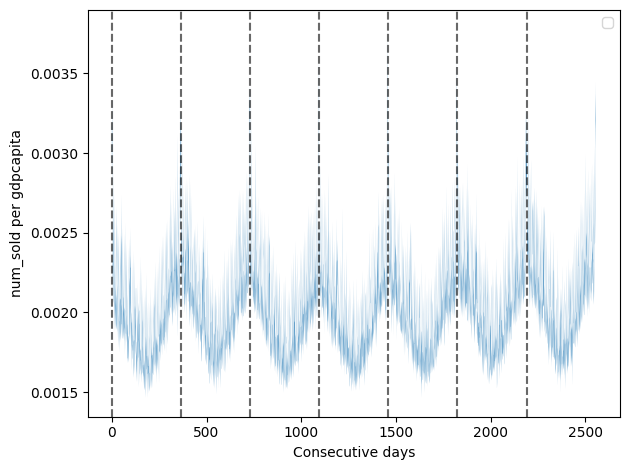

In [60]:
#There is no data for Canada, Discount Stickers, Holographic Goose
#There is no data for Kenya, Discount Stickers, Holographic Goose
#Let's look at other products in Canada and Kenya in the same store see if we can find any relation

#let's look at other countries for same store and product and see if there is any relation
store_all_values = []
for country in data_non_missing["country"].unique():
    if country != "Canada" and country != "Kenya":
        data_other = data_non_missing[(data_non_missing["country"] == country) & (data_non_missing["store"] == "Discount Stickers") & (data_non_missing["product"] == "Holographic Goose")]
        data_other["date"] = pd.to_datetime(data_other["date"], format="%Y-%m-%d")
        data_other["day_of_year"] = data_other["date"].dt.day_of_year
        data_other["year"] = data_other["date"].dt.year -2010
        data_other["consecutive_days"] = data_other["day_of_year"] + data_other["year"]*365
        if data_other.empty:
            print("No data for ", country, "Discount Stickers, Holographic Goose")
        else:
            #plt.plot(data_other["num_sold"],label=country)
            #rolling average
            gdp_per_capita = [gdp_data[country][str(i+2010)] for i in data_other["year"]]
            num_sold_per_gdp = data_other["num_sold"].rolling(window=1).mean()/gdp_per_capita
            store_all_values.append(num_sold_per_gdp)
            #plt.plot(data_other["consecutive_days"],num_sold_per_gdp,label=country,alpha=0.8)
            #plot vertical line for each year
            for year in data_other["year"].unique():
                plt.axvline(x=year*365,color="black",linestyle="--",alpha=0.2)
  
store_all_values = np.array(store_all_values)
std_values = np.std(store_all_values,axis=0)
mean_values = np.mean(store_all_values,axis=0)
plt.fill_between(range(len(mean_values)),mean_values-std_values,mean_values+std_values,alpha=0.7)
plt.ylabel("num_sold per gdpcapita")           
plt.xlabel("Consecutive days")           
plt.legend()
plt.tight_layout()
plt.show()


In [71]:
nan_values = data["num_sold"].isna()
missing_values = data.loc[nan_values]

#can I plot a pie chart of the missing values for each country, store, product
missing_values.groupby(["country", "store", "product"])["id"].count()


country  store                 product           
Canada   Discount Stickers     Holographic Goose     2557
                               Kerneler                 1
         Premium Sticker Mart  Holographic Goose      380
         Stickers for Less     Holographic Goose     1308
Kenya    Discount Stickers     Holographic Goose     2557
                               Kerneler                63
                               Kerneler Dark Mode       1
         Premium Sticker Mart  Holographic Goose      646
         Stickers for Less     Holographic Goose     1358
Name: id, dtype: int64

In [52]:
from xgboost import XGBRegressor
import optuna
from sklearn.metrics import mean_squared_error
X = train_data.drop(columns=['num_sold'])
y = train_data['num_sold']

cat_cols = ['country', 'store', 'product']
num_cols = ["sin_dayofweek", "cos_dayofweek", "sin_month", "cos_month", "sin_year", "cos_year","gdp_per_capita"]

# Create different preprocessors for different models
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

# For models that need one-hot encoding (XGBoost, RandomForest)
categorical_transformer_ohe = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# Create different preprocessors
preprocessor_ohe = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols),
    ('cat', categorical_transformer_ohe, cat_cols)
])

# For LightGBM and CatBoost, we'll just scale numerics and pass categoricals as is
preprocessor_native = ColumnTransformer(transformers=[
    ('num', numeric_transformer, num_cols)
])

model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor_ohe),
    ('regressor', XGBRegressor(
        n_estimators=5000,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    ))
])

def objective(trial):
    
    #params max_depth, min_child_weight, gamma, learning_rate
    max_depth = trial.suggest_int("max_depth", 3, 10)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    gamma = trial.suggest_int("gamma", 0, 10)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3)
    n_estimators = trial.suggest_int("n_estimators", 100, 5000)
    subsample = trial.suggest_float("subsample", 0.5, 1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1)
    colsample_bylevel = trial.suggest_float("colsample_bylevel", 0.5, 1)
    colsample_bynode = trial.suggest_float("colsample_bynode", 0.5, 1)
    lambda_l1 = trial.suggest_float("lambda_l1", 0, 10)
    lambda_l2 = trial.suggest_float("lambda_l2", 0, 10)
    
    model_pipeline = Pipeline(steps=[
        ('preprocessor', preprocessor_ohe),
        ('regressor', XGBRegressor(
            n_estimators=n_estimators,
            learning_rate=learning_rate,
            max_depth=max_depth,
            min_child_weight=min_child_weight,
            gamma=gamma,
            random_state=42,
            objective='reg:squarederror',
            booster="gbtree",
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            colsample_bylevel=colsample_bylevel,
            colsample_bynode=colsample_bynode,
            reg_alpha=lambda_l1,
            reg_lambda=lambda_l2
        ))
    ])
    #Time-series cross-validation
    time_series = TimeSeriesSplit(n_splits=5)
    fold_scores_val= []
    fold_scores_train= []
    loss_train= []
    loss_val= []
    model_name = "xgboost"
    for fold_index, (train_index, val_index) in enumerate(time_series.split(X)):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]
        
        y_train_fold_transformed = np.log1p(y_train_fold)
        y_val_fold_transformed = np.log1p(y_val_fold)
        
        model_pipeline.fit(X_train_fold, y_train_fold_transformed)
        
        y_pred_val = model_pipeline.predict(X_val_fold)    
        y_pred_train = model_pipeline.predict(X_train_fold)
        
        y_pred_val_transformed = np.expm1(y_pred_val)
        y_pred_train_transformed = np.expm1(y_pred_train)
        
        mape_val = mean_absolute_percentage_error(y_val_fold, y_pred_val_transformed)
        mape_train = mean_absolute_percentage_error(y_train_fold, y_pred_train_transformed)
        
        mse_train = mean_squared_error(y_train_fold, y_pred_train_transformed)
        mse_val = mean_squared_error(y_val_fold, y_pred_val_transformed)
        
        fold_scores_val.append(mape_val)
        fold_scores_train.append(mape_train)
        loss_train.append(mse_train)
        loss_val.append(mse_val)
        
        # print(f"Fold {fold_index + 1} loss train: {mse_train:.4f}")
        # print(f"Fold {fold_index + 1} loss val: {mse_val:.4f}")
        # print("--------------------------------")
        # print(f"Fold {fold_index + 1} metric val: {mape_val:.4f}")
        # print(f"Fold {fold_index + 1} metric train: {mape_train:.4f}")
        # print("--------------------------------")
        
    print(f"Average MAPE for {model_name}: {np.mean(fold_scores_val):.4f}")
    print(f"Average MAPE for {model_name} train: {np.mean(fold_scores_train):.4f}")
    # print(f"Average MSE for {model_name} train: {np.mean(loss_train):.4f}")
    # print(f"Average MSE for {model_name} val: {np.mean(loss_val):.4f}")
    
    return np.mean(fold_scores_val)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=40)
print(f"Best parameters: {study.best_params}")
print(f"Best value: {study.best_value:.4f}")





[I 2025-01-16 16:34:52,482] A new study created in memory with name: no-name-72847431-4a7e-4fb7-9978-d05694d5cd81
[I 2025-01-16 16:35:10,655] Trial 0 finished with value: 0.11807659092352815 and parameters: {'max_depth': 6, 'min_child_weight': 6, 'gamma': 2, 'learning_rate': 0.03210282192067468, 'n_estimators': 3261, 'subsample': 0.949424738025167, 'colsample_bytree': 0.5029583642161533, 'colsample_bylevel': 0.5382799441251553, 'colsample_bynode': 0.8986506537411352, 'lambda_l1': 2.1855846278041904, 'lambda_l2': 4.125673362137149}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1181
Average MAPE for xgboost train: 0.0797


[I 2025-01-16 16:35:19,992] Trial 1 finished with value: 0.13838218584123013 and parameters: {'max_depth': 6, 'min_child_weight': 1, 'gamma': 9, 'learning_rate': 0.24911483575403864, 'n_estimators': 1701, 'subsample': 0.6497220519552172, 'colsample_bytree': 0.6022149668472376, 'colsample_bylevel': 0.8213186240503774, 'colsample_bynode': 0.7156281719468283, 'lambda_l1': 6.067743097258278, 'lambda_l2': 1.0415614401389683}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1384
Average MAPE for xgboost train: 0.1001


[I 2025-01-16 16:35:24,823] Trial 2 finished with value: 0.12732270208841187 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'gamma': 8, 'learning_rate': 0.21064401442874833, 'n_estimators': 695, 'subsample': 0.7634215097262399, 'colsample_bytree': 0.6736460183024124, 'colsample_bylevel': 0.6779695598593198, 'colsample_bynode': 0.8379940412781617, 'lambda_l1': 4.824720648424304, 'lambda_l2': 3.7571000116842876}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1273
Average MAPE for xgboost train: 0.0867


[I 2025-01-16 16:35:33,557] Trial 3 finished with value: 0.12634108543776904 and parameters: {'max_depth': 3, 'min_child_weight': 3, 'gamma': 7, 'learning_rate': 0.01822147428766681, 'n_estimators': 872, 'subsample': 0.6569175312765122, 'colsample_bytree': 0.9315497957253929, 'colsample_bylevel': 0.7816398633415719, 'colsample_bynode': 0.5210043294761082, 'lambda_l1': 3.8855397060503014, 'lambda_l2': 0.7755229103908323}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1263
Average MAPE for xgboost train: 0.0933


[I 2025-01-16 16:35:42,606] Trial 4 finished with value: 0.13151187061385575 and parameters: {'max_depth': 4, 'min_child_weight': 9, 'gamma': 10, 'learning_rate': 0.27472147876526454, 'n_estimators': 1917, 'subsample': 0.9486309507374315, 'colsample_bytree': 0.6088562590621001, 'colsample_bylevel': 0.8107555978199957, 'colsample_bynode': 0.7631599619566456, 'lambda_l1': 2.4467581698303045, 'lambda_l2': 8.714379563861664}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1315
Average MAPE for xgboost train: 0.0955


[I 2025-01-16 16:35:50,905] Trial 5 finished with value: 0.12613223583954497 and parameters: {'max_depth': 10, 'min_child_weight': 3, 'gamma': 2, 'learning_rate': 0.07635464461941405, 'n_estimators': 1144, 'subsample': 0.784583287842737, 'colsample_bytree': 0.509305772130979, 'colsample_bylevel': 0.6883312677069466, 'colsample_bynode': 0.64527824263564, 'lambda_l1': 4.736703769566248, 'lambda_l2': 4.920932971286915}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1261
Average MAPE for xgboost train: 0.0865


[I 2025-01-16 16:36:08,379] Trial 6 finished with value: 0.13922244636093745 and parameters: {'max_depth': 3, 'min_child_weight': 4, 'gamma': 4, 'learning_rate': 0.16023306303891938, 'n_estimators': 3735, 'subsample': 0.7467032270746239, 'colsample_bytree': 0.6751005099121052, 'colsample_bylevel': 0.5655626527586053, 'colsample_bynode': 0.9159065011831459, 'lambda_l1': 8.851876273155451, 'lambda_l2': 1.3143508555826455}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1392
Average MAPE for xgboost train: 0.0979


[I 2025-01-16 16:36:16,672] Trial 7 finished with value: 0.1428997165787644 and parameters: {'max_depth': 5, 'min_child_weight': 10, 'gamma': 9, 'learning_rate': 0.12321704977120809, 'n_estimators': 1494, 'subsample': 0.6605304388429736, 'colsample_bytree': 0.5516432973000405, 'colsample_bylevel': 0.7545433192191305, 'colsample_bynode': 0.5216081836331032, 'lambda_l1': 3.0935155106627645, 'lambda_l2': 7.4198069810308915}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1429
Average MAPE for xgboost train: 0.1049


[I 2025-01-16 16:36:23,356] Trial 8 finished with value: 0.12516182241080326 and parameters: {'max_depth': 7, 'min_child_weight': 1, 'gamma': 3, 'learning_rate': 0.19701380278835395, 'n_estimators': 1091, 'subsample': 0.6130238896367153, 'colsample_bytree': 0.6144892437442631, 'colsample_bylevel': 0.5943330264168319, 'colsample_bynode': 0.9926828331526092, 'lambda_l1': 4.6826276636745, 'lambda_l2': 1.4355355238609457}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1252
Average MAPE for xgboost train: 0.0822


[I 2025-01-16 16:36:42,168] Trial 9 finished with value: 0.12987342007356928 and parameters: {'max_depth': 5, 'min_child_weight': 5, 'gamma': 5, 'learning_rate': 0.28915276395699563, 'n_estimators': 3668, 'subsample': 0.5204175138474134, 'colsample_bytree': 0.6200552890271958, 'colsample_bylevel': 0.6373940656952928, 'colsample_bynode': 0.8773107183676361, 'lambda_l1': 7.288299904654892, 'lambda_l2': 6.444490419370448}. Best is trial 0 with value: 0.11807659092352815.


Average MAPE for xgboost: 0.1299
Average MAPE for xgboost train: 0.0895


[I 2025-01-16 16:38:54,913] Trial 10 finished with value: 0.10557785009981309 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'gamma': 0, 'learning_rate': 0.01505765748078685, 'n_estimators': 4717, 'subsample': 0.9850854435290706, 'colsample_bytree': 0.8369888893630073, 'colsample_bylevel': 0.9418916410152316, 'colsample_bynode': 0.9992012805619199, 'lambda_l1': 0.24748460633957325, 'lambda_l2': 3.372128735140093}. Best is trial 10 with value: 0.10557785009981309.


Average MAPE for xgboost: 0.1056
Average MAPE for xgboost train: 0.0484


[I 2025-01-16 16:41:08,928] Trial 11 finished with value: 0.10870133860759508 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'gamma': 0, 'learning_rate': 0.014065259355761086, 'n_estimators': 4927, 'subsample': 0.997585923746086, 'colsample_bytree': 0.8630346598161984, 'colsample_bylevel': 0.9900537617159049, 'colsample_bynode': 0.9918347080865404, 'lambda_l1': 0.09348716129778634, 'lambda_l2': 3.356640457215393}. Best is trial 10 with value: 0.10557785009981309.


Average MAPE for xgboost: 0.1087
Average MAPE for xgboost train: 0.0479


[I 2025-01-16 16:42:59,726] Trial 12 finished with value: 0.10606636135815586 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'gamma': 0, 'learning_rate': 0.07678228663476888, 'n_estimators': 4998, 'subsample': 0.9989948819667895, 'colsample_bytree': 0.868174778072526, 'colsample_bylevel': 0.9985984549697022, 'colsample_bynode': 0.9834072219623191, 'lambda_l1': 0.2044447499008203, 'lambda_l2': 2.9663559269528457}. Best is trial 10 with value: 0.10557785009981309.


Average MAPE for xgboost: 0.1061
Average MAPE for xgboost train: 0.0476


[I 2025-01-16 16:45:19,985] Trial 13 finished with value: 0.10653131827383433 and parameters: {'max_depth': 8, 'min_child_weight': 7, 'gamma': 0, 'learning_rate': 0.08097253288808902, 'n_estimators': 4938, 'subsample': 0.874565333712226, 'colsample_bytree': 0.8088265528085625, 'colsample_bylevel': 0.9813192466803926, 'colsample_bynode': 0.996590412903084, 'lambda_l1': 0.17789829687390982, 'lambda_l2': 2.776840707709182}. Best is trial 10 with value: 0.10557785009981309.


Average MAPE for xgboost: 0.1065
Average MAPE for xgboost train: 0.0471


[I 2025-01-16 16:45:39,823] Trial 14 finished with value: 0.10352410512731205 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'gamma': 1, 'learning_rate': 0.07051399098173243, 'n_estimators': 4163, 'subsample': 0.8638027156505762, 'colsample_bytree': 0.9459978920418202, 'colsample_bylevel': 0.918173397551972, 'colsample_bynode': 0.8260483503296513, 'lambda_l1': 1.4632786326806335, 'lambda_l2': 5.605898329678194}. Best is trial 14 with value: 0.10352410512731205.


Average MAPE for xgboost: 0.1035
Average MAPE for xgboost train: 0.0600


[I 2025-01-16 16:45:59,948] Trial 15 finished with value: 0.1097066611054079 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'gamma': 2, 'learning_rate': 0.10927810550252809, 'n_estimators': 4194, 'subsample': 0.859617999452158, 'colsample_bytree': 0.9739197346956068, 'colsample_bylevel': 0.9007258942517714, 'colsample_bynode': 0.8015434377807225, 'lambda_l1': 1.5538461766199367, 'lambda_l2': 6.062531126940259}. Best is trial 14 with value: 0.10352410512731205.


Average MAPE for xgboost: 0.1097
Average MAPE for xgboost train: 0.0639


[I 2025-01-16 16:46:17,288] Trial 16 finished with value: 0.11223154946949783 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'gamma': 6, 'learning_rate': 0.046920870533744004, 'n_estimators': 2823, 'subsample': 0.8567379231673585, 'colsample_bytree': 0.7705104475892145, 'colsample_bylevel': 0.8832712529068157, 'colsample_bynode': 0.6735478836269241, 'lambda_l1': 1.319442429202056, 'lambda_l2': 5.435412082901708}. Best is trial 14 with value: 0.10352410512731205.


Average MAPE for xgboost: 0.1122
Average MAPE for xgboost train: 0.0772


[I 2025-01-16 16:46:40,820] Trial 17 finished with value: 0.1035825211411083 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 1, 'learning_rate': 0.051632867261087824, 'n_estimators': 4203, 'subsample': 0.9354001842286569, 'colsample_bytree': 0.9899221627157972, 'colsample_bylevel': 0.8934082085366941, 'colsample_bynode': 0.6081910883283272, 'lambda_l1': 1.0913491614483215, 'lambda_l2': 9.956003951182353}. Best is trial 14 with value: 0.10352410512731205.


Average MAPE for xgboost: 0.1036
Average MAPE for xgboost train: 0.0612


[I 2025-01-16 16:46:53,611] Trial 18 finished with value: 0.11300217733132352 and parameters: {'max_depth': 10, 'min_child_weight': 5, 'gamma': 4, 'learning_rate': 0.13410788508470495, 'n_estimators': 2461, 'subsample': 0.9104897128056186, 'colsample_bytree': 0.9898194602606494, 'colsample_bylevel': 0.8722616382376185, 'colsample_bynode': 0.5946150722736674, 'lambda_l1': 3.3704917225752666, 'lambda_l2': 9.9911664248834}. Best is trial 14 with value: 0.10352410512731205.


Average MAPE for xgboost: 0.1130
Average MAPE for xgboost train: 0.0719


[I 2025-01-16 16:47:17,058] Trial 19 finished with value: 0.10596201366330897 and parameters: {'max_depth': 9, 'min_child_weight': 4, 'gamma': 1, 'learning_rate': 0.05974410358036866, 'n_estimators': 4091, 'subsample': 0.8003851741970746, 'colsample_bytree': 0.9222903331034368, 'colsample_bylevel': 0.84339103701553, 'colsample_bynode': 0.5949700652171287, 'lambda_l1': 9.982691080060377, 'lambda_l2': 7.650143240215039}. Best is trial 14 with value: 0.10352410512731205.


Average MAPE for xgboost: 0.1060
Average MAPE for xgboost train: 0.0660


[I 2025-01-16 16:47:32,030] Trial 20 finished with value: 0.11433130439661143 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'gamma': 3, 'learning_rate': 0.15852127436621144, 'n_estimators': 3035, 'subsample': 0.8327218069071227, 'colsample_bytree': 0.9223140938084388, 'colsample_bylevel': 0.9395500356254332, 'colsample_bynode': 0.7336033134623402, 'lambda_l1': 6.0547497159254124, 'lambda_l2': 9.905465009968522}. Best is trial 14 with value: 0.10352410512731205.


Average MAPE for xgboost: 0.1143
Average MAPE for xgboost train: 0.0710


[I 2025-01-16 16:47:52,344] Trial 21 finished with value: 0.103308223291978 and parameters: {'max_depth': 9, 'min_child_weight': 8, 'gamma': 1, 'learning_rate': 0.0972829691594794, 'n_estimators': 4429, 'subsample': 0.9123938280185914, 'colsample_bytree': 0.8756512030150148, 'colsample_bylevel': 0.9292692634313228, 'colsample_bynode': 0.8488059477117, 'lambda_l1': 1.317836133596888, 'lambda_l2': 2.1027035251210964}. Best is trial 21 with value: 0.103308223291978.


Average MAPE for xgboost: 0.1033
Average MAPE for xgboost train: 0.0601


[I 2025-01-16 16:48:11,622] Trial 22 finished with value: 0.10597520061745525 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'gamma': 1, 'learning_rate': 0.09579695289562808, 'n_estimators': 4304, 'subsample': 0.9192788613258278, 'colsample_bytree': 0.9507102593735397, 'colsample_bylevel': 0.9214214450885095, 'colsample_bynode': 0.8274354461446616, 'lambda_l1': 1.431936398069057, 'lambda_l2': 2.1732961874376935}. Best is trial 21 with value: 0.103308223291978.


Average MAPE for xgboost: 0.1060
Average MAPE for xgboost train: 0.0597


[I 2025-01-16 16:48:31,489] Trial 23 finished with value: 0.10288135676829621 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'gamma': 1, 'learning_rate': 0.05968741900351801, 'n_estimators': 3554, 'subsample': 0.9061519957890064, 'colsample_bytree': 0.9987735356751825, 'colsample_bylevel': 0.8528314011305994, 'colsample_bynode': 0.7882619802097119, 'lambda_l1': 1.1548852044721485, 'lambda_l2': 0.08513630864398669}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1029
Average MAPE for xgboost train: 0.0595


[I 2025-01-16 16:48:48,029] Trial 24 finished with value: 0.10711789451286809 and parameters: {'max_depth': 10, 'min_child_weight': 9, 'gamma': 3, 'learning_rate': 0.13564329757349852, 'n_estimators': 3540, 'subsample': 0.8912198016092611, 'colsample_bytree': 0.8921536338990985, 'colsample_bylevel': 0.8452315095435737, 'colsample_bynode': 0.7768783960292678, 'lambda_l1': 2.394318407817358, 'lambda_l2': 0.13677042349468135}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1071
Average MAPE for xgboost train: 0.0683


[I 2025-01-16 16:48:51,280] Trial 25 finished with value: 0.10658480058418755 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'gamma': 1, 'learning_rate': 0.0970556504791451, 'n_estimators': 271, 'subsample': 0.825276800651338, 'colsample_bytree': 0.7829640326242447, 'colsample_bylevel': 0.9549130966104385, 'colsample_bynode': 0.8597470116905578, 'lambda_l1': 3.59744952960688, 'lambda_l2': 2.111261130094262}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1066
Average MAPE for xgboost train: 0.0619


[I 2025-01-16 16:49:16,590] Trial 26 finished with value: 0.11154011923408688 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'gamma': 4, 'learning_rate': 0.056342097810849916, 'n_estimators': 4535, 'subsample': 0.7244778712326337, 'colsample_bytree': 0.896354939798843, 'colsample_bylevel': 0.7312157281183761, 'colsample_bynode': 0.8015439765983196, 'lambda_l1': 0.9784261845340613, 'lambda_l2': 0.101890272912702}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1115
Average MAPE for xgboost train: 0.0714


[I 2025-01-16 16:49:28,330] Trial 27 finished with value: 0.11376598446748391 and parameters: {'max_depth': 9, 'min_child_weight': 9, 'gamma': 2, 'learning_rate': 0.10974834833337457, 'n_estimators': 2391, 'subsample': 0.8216865981055351, 'colsample_bytree': 0.7282120961849072, 'colsample_bylevel': 0.7946394293953314, 'colsample_bynode': 0.9406623422117931, 'lambda_l1': 2.004236397837468, 'lambda_l2': 4.603499002936451}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1138
Average MAPE for xgboost train: 0.0680


[I 2025-01-16 16:49:47,628] Trial 28 finished with value: 0.11197321880841068 and parameters: {'max_depth': 10, 'min_child_weight': 10, 'gamma': 5, 'learning_rate': 0.03491179667542156, 'n_estimators': 3896, 'subsample': 0.8925999447387535, 'colsample_bytree': 0.9564348523604483, 'colsample_bylevel': 0.8555452773428873, 'colsample_bynode': 0.6974750932210954, 'lambda_l1': 2.9193569956874006, 'lambda_l2': 1.936138897119882}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1120
Average MAPE for xgboost train: 0.0726


[I 2025-01-16 16:50:02,501] Trial 29 finished with value: 0.1113224879148315 and parameters: {'max_depth': 7, 'min_child_weight': 6, 'gamma': 2, 'learning_rate': 0.1803220196138124, 'n_estimators': 3338, 'subsample': 0.9551950128783478, 'colsample_bytree': 0.9975882180370836, 'colsample_bylevel': 0.9102876568451818, 'colsample_bynode': 0.8943096473054039, 'lambda_l1': 1.9949211718034823, 'lambda_l2': 4.424553327742592}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1113
Average MAPE for xgboost train: 0.0645


[I 2025-01-16 16:50:21,760] Trial 30 finished with value: 0.11007746038074613 and parameters: {'max_depth': 8, 'min_child_weight': 8, 'gamma': 1, 'learning_rate': 0.0685631973433338, 'n_estimators': 3225, 'subsample': 0.7073027235669472, 'colsample_bytree': 0.828378469938625, 'colsample_bylevel': 0.9623292132253678, 'colsample_bynode': 0.9424867858681372, 'lambda_l1': 0.9010640418501864, 'lambda_l2': 5.426201865956773}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1101
Average MAPE for xgboost train: 0.0615


[I 2025-01-16 16:50:44,879] Trial 31 finished with value: 0.10546041906318752 and parameters: {'max_depth': 9, 'min_child_weight': 5, 'gamma': 1, 'learning_rate': 0.041997354362610484, 'n_estimators': 4452, 'subsample': 0.94659106730184, 'colsample_bytree': 0.9593667176815492, 'colsample_bylevel': 0.8973781456152613, 'colsample_bynode': 0.7984842565562487, 'lambda_l1': 0.8087178485277708, 'lambda_l2': 8.581896486921078}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1055
Average MAPE for xgboost train: 0.0599


[I 2025-01-16 16:51:03,235] Trial 32 finished with value: 0.11488905465793017 and parameters: {'max_depth': 9, 'min_child_weight': 6, 'gamma': 3, 'learning_rate': 0.0922748026462229, 'n_estimators': 4088, 'subsample': 0.9345968819383135, 'colsample_bytree': 0.9968238685512529, 'colsample_bylevel': 0.9273287927390105, 'colsample_bynode': 0.8345475729725649, 'lambda_l1': 1.7493656663488286, 'lambda_l2': 7.261797351708447}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1149
Average MAPE for xgboost train: 0.0659


[I 2025-01-16 16:51:23,584] Trial 33 finished with value: 0.10490370235166979 and parameters: {'max_depth': 9, 'min_child_weight': 7, 'gamma': 1, 'learning_rate': 0.0327505756115971, 'n_estimators': 3952, 'subsample': 0.9677313658982932, 'colsample_bytree': 0.8870040554439864, 'colsample_bylevel': 0.827769508447613, 'colsample_bynode': 0.7143800192336339, 'lambda_l1': 2.622787365234312, 'lambda_l2': 0.664387051089407}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1049
Average MAPE for xgboost train: 0.0616


[I 2025-01-16 16:51:45,508] Trial 34 finished with value: 0.10715831744552104 and parameters: {'max_depth': 10, 'min_child_weight': 8, 'gamma': 2, 'learning_rate': 0.05118422945877486, 'n_estimators': 4511, 'subsample': 0.8996090393134265, 'colsample_bytree': 0.9314871048425224, 'colsample_bylevel': 0.8824483863004334, 'colsample_bynode': 0.8569766710760834, 'lambda_l1': 0.8160412198933005, 'lambda_l2': 9.135632183890836}. Best is trial 23 with value: 0.10288135676829621.


Average MAPE for xgboost: 0.1072
Average MAPE for xgboost train: 0.0637


[I 2025-01-16 16:52:46,621] Trial 35 finished with value: 0.10140950037147187 and parameters: {'max_depth': 6, 'min_child_weight': 4, 'gamma': 0, 'learning_rate': 0.06615282525075616, 'n_estimators': 3553, 'subsample': 0.853394529197838, 'colsample_bytree': 0.9682703655445162, 'colsample_bylevel': 0.511611621403479, 'colsample_bynode': 0.7401768150932548, 'lambda_l1': 2.0124351280364996, 'lambda_l2': 6.601717317358692}. Best is trial 35 with value: 0.10140950037147187.


Average MAPE for xgboost: 0.1014
Average MAPE for xgboost train: 0.0505


[I 2025-01-16 16:53:31,032] Trial 36 finished with value: 0.10076405972525863 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.11825976074096232, 'n_estimators': 2793, 'subsample': 0.7850832370287776, 'colsample_bytree': 0.9054260884165223, 'colsample_bylevel': 0.5190881594108687, 'colsample_bynode': 0.7441147514450479, 'lambda_l1': 4.363187617706555, 'lambda_l2': 6.46747057065161}. Best is trial 36 with value: 0.10076405972525863.


Average MAPE for xgboost: 0.1008
Average MAPE for xgboost train: 0.0514


[I 2025-01-16 16:54:05,708] Trial 37 finished with value: 0.10283101741895048 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.14005613296603947, 'n_estimators': 2065, 'subsample': 0.7558673018274455, 'colsample_bytree': 0.903541867000623, 'colsample_bylevel': 0.5025370022554937, 'colsample_bynode': 0.7585331861431308, 'lambda_l1': 3.9637306772137193, 'lambda_l2': 6.690324406286998}. Best is trial 36 with value: 0.10076405972525863.


Average MAPE for xgboost: 0.1028
Average MAPE for xgboost train: 0.0514


[I 2025-01-16 16:54:49,366] Trial 38 finished with value: 0.09904048200134594 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.2438853390687511, 'n_estimators': 2710, 'subsample': 0.7743750640122247, 'colsample_bytree': 0.917406591244253, 'colsample_bylevel': 0.5210269372262178, 'colsample_bynode': 0.7470861674929081, 'lambda_l1': 4.1022383032551675, 'lambda_l2': 6.541399171171751}. Best is trial 38 with value: 0.09904048200134594.


Average MAPE for xgboost: 0.0990
Average MAPE for xgboost train: 0.0514


[I 2025-01-16 16:55:21,904] Trial 39 finished with value: 0.09707012984999255 and parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.22526539269160925, 'n_estimators': 2000, 'subsample': 0.7504843677097007, 'colsample_bytree': 0.9058833944527335, 'colsample_bylevel': 0.5023703000686878, 'colsample_bynode': 0.7460010757653904, 'lambda_l1': 4.13721855361009, 'lambda_l2': 6.767325827239311}. Best is trial 39 with value: 0.09707012984999255.


Average MAPE for xgboost: 0.0971
Average MAPE for xgboost train: 0.0515
Best parameters: {'max_depth': 6, 'min_child_weight': 2, 'gamma': 0, 'learning_rate': 0.22526539269160925, 'n_estimators': 2000, 'subsample': 0.7504843677097007, 'colsample_bytree': 0.9058833944527335, 'colsample_bylevel': 0.5023703000686878, 'colsample_bynode': 0.7460010757653904, 'lambda_l1': 4.13721855361009, 'lambda_l2': 6.767325827239311}
Best value: 0.0971
